<center><h1 class="workshop-title">Workshop 2<br>Non-Parametric Density Estimation</h1></center>

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/doodle/96/000000/taxi.png"> The NYC Taxi Dataset 

As part of the effort of NYC to make its data publicly available and accessible, the city releases every month the full list of all taxi rides around the city. We will be using the dataset from January 2016, which can be found [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

The full dataset includes over 10M taxi rides. In our course, we will be using a smaller subset of this dataset with only 100k rides (which has also been cleaned up a bit). The smaller dataset can be found [here](https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv)

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/help.png"> Problem: Estimating the Distribution of Trip Duration

A taxi driver would like to give an estimation for the distributions of trip durations. He has taken the course in machine learning and has figured that he can use historical rides data to estimate this distribution. Let us help the driver with his estimation.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/process.png"> The Workflow

**Distribution Estimation Evaluation**: The subject of evaluating how good a distribution fits a set of sampled data is an important one, but it is outside the scope of this course. Therefore, for the next two workshops, we will skip the evaluation step in our workflow.

The workflow is then:

<center><img src="../media/diagrams/workflow_density_estimation.png" width="300px" style="width:300px"/></center>

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/ultraviolet/40/000000/normal-distribution-histogram.png"> Applying the Workflow

We will start by importing some useful packages

In [1]:
# Importing packages
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 5.0)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 90  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## A function to add Latex (equations) to output which works also in Google Colabrtroy
## In a regular notebook this could simply be replaced with "display(Markdown(x))"
from IPython.display import HTML
def print_math(x):  # Define a function to preview markdown outputs as HTML using mathjax
    display(HTML(''.join(['<p><script type="text/x-mathjax-config">MathJax.Hub.Config({tex2jax: {inlineMath: [[\'$\',\'$\'], [\'\\\\(\',\'\\\\)\']]}});</script><script src=\'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=TeX-AMS_CHTML\'></script>',x,'</p>'])))

#  <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/color/96/000000/view-file.png"> Data Inspection

We will start by loading the data and taking a look at it by printing out the 10 first rows.

- The data can be found at [https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv](https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv) 

In [2]:
data_file = 'https://technion046195.github.io/semester_2019_spring/datasets/nyc_taxi_rides.csv'

## Loading the data
dataset = pd.read_csv(data_file)

## Print the number of rows in the data set
number_of_rows = len(dataset)
print_math('Number of rows in the dataset: $N={}$'.format(number_of_rows))

## Show the first 10 rows
dataset.head(10)

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,pickup_easting,pickup_northing,dropoff_easting,dropoff_northing,duration,day_of_week,day_of_month,time_of_day
0,2,2.768065,2,9.5,0.00,586.996941,4512.979705,588.155118,4515.180889,11.516667,3,13,12.801944
1,1,3.218680,2,10.0,0.00,587.151523,4512.923924,584.850489,4512.632082,12.666667,6,16,20.961389
2,1,2.574944,1,7.0,2.49,587.005357,4513.359700,585.434188,4513.174964,5.516667,0,31,20.412778
3,1,0.965604,1,7.5,1.65,586.648975,4511.729212,586.671530,4512.554065,9.883333,1,25,13.031389
4,1,2.462290,1,7.5,1.66,586.967178,4511.894301,585.262474,4511.755477,8.683333,2,5,7.703333
5,5,1.561060,1,7.5,2.20,585.926415,4512.880385,585.168973,4511.540103,9.433333,3,20,20.667222
6,1,2.574944,1,8.0,1.00,586.731409,4515.084445,588.710175,4514.209184,7.950000,5,8,23.841944
7,1,0.804670,2,5.0,0.00,585.344614,4509.712541,585.843967,4509.545089,4.950000,5,29,15.831389
8,1,3.653202,1,10.0,1.10,585.422062,4509.477536,583.671081,4507.735573,11.066667,5,8,2.098333
9,6,1.625433,1,5.5,1.36,587.875433,4514.931073,587.701248,4513.709691,4.216667,3,13,21.783056


## The Data Fields and Types
In this exercise we will only be interested in the following columns:

- **duration**: The total duration of the ride (in minutes)
- **time_of_day**: A number between 0 and 24 indicating the time of the pickup. The integer part is the hour in 24H format and the decimal part are the minutes and seconds

(A full description for each of the other columns can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf))

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/doodle/96/000000/multi-edit.png"> Problem Definition


## <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.1 - The Underlying Process

For the random phenomenon generating the taxi rides data, define or make-up examples for:
- A sample
- 3 random variable
- An event
- A probability measure

### Solution 2.1

- **A sample**: A single taxi ride, for example, $\omega$: A ride from downtown to central park, which began at 8:15 and took 30 minutes.
- **Random variables**:
 - A function which returns the ride's duration in hours as a real number. (A continues random variable): $X_\text{duration}\left(\omega\right)=0.5$
  - A function which returns the pickup hour of the day as an integer between 0 and 23. (A discrete random variable): $X_\text{hour}\left(\omega\right)=8$
  - A function which returns 1 if the ride ended to the west of East River and 0 if it ended to the east of it. (A binary random variable): $X_\text{East River}\left(\omega\right)=1$
- **An event**: A set of taxi rides, For example, all taxi rides which started before 11 a.m: $A=\left\{\omega,X_\text{hour}(\omega)<11\right\}$
- **Probability measure**: For example, the probability of a randomly generated ride to start before 11 a.m. $P\left(A\right)=\tfrac{1}{3}$

## The Task and the Goal

Our task here is to estimate the distribution of the rides durations. We will represent it as a CDF or a PDF.

## Splitting the dataset

We will split the data into 80% train set and 20% test set for later evaluations

In [3]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed (this is important to make our result reproducible)
rand_gen = np.random.RandomState(0)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 80% train / 20% test
n_samples_train = int(n_samples * 0.8)
n_samples_test = n_samples - n_samples_train
train_indices = indices[:n_samples_train]
test_indices = indices[n_samples_train:]

train_set = dataset.iloc[train_indices]
test_set = dataset.iloc[test_indices]

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/color/96/000000/idea-sharing.png"> Model & Learning Method Suggestion 1 : ECDF

We shall start be trying to estimate the CDF of the distribution using the ECDF.

In this case the ECDF defines both the model which we will be using and the way to calculate it. In the general case, as we will see in the next workshop, the model and the method used to calculate a model based on the model can be two separate things.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/services.png"> Learning

We will now turn to actually calculate the ECDF from the data.

## <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.2 - ECDF

1. Calculate and plot the ECDF of the durations.
2. According to the ECDF graph, what is the estimated probability of a ride to have a duration longer than 20 min?

### Solution 2.2

#### 1)

We shall calculate the ECDF over a grid of durations.

**Reminder**, the ECDF is defined as:

$$
\hat{F}_{X}\left(x\right)=\tfrac{1}{N}\sum_{i=1}^N I\left\{x_i \leq x\right\}
$$


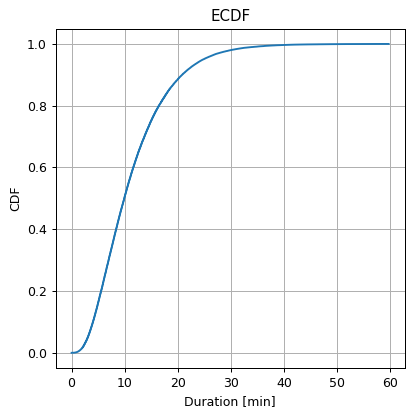

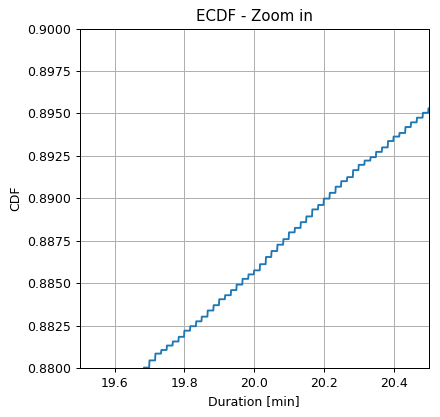

In [4]:
def calculate_ecdf(x, duration_grid):
    
    ## Initialize a an array for the calculated ECDF
    ecdf = np.zeros(duration_grid.shape)
    
    ## Calculate the ECDF by definition
    for i, duration in enumerate(duration_grid):   # enumerate adds an index to the list's values
        ecdf[i] = (x <= duration).mean()
    
    return ecdf
    

## extarcting the samples
x = train_set['duration'].values

## Define the grid
duration_grid = np.arange(0, x.max() + 0.001, 0.001)  # We add the step size to the end of the range to include the endpoint

## Create the ECDF
ecdf = calculate_ecdf(x, duration_grid)

# plot the ECDF
fig, ax = plt.subplots()
ax.plot(duration_grid, ecdf)
ax.set_title('ECDF')
ax.set_ylabel('CDF')
ax.set_xlabel('Duration [min]')

## Plot a zoomed in version
fig, ax = plt.subplots()
ax.plot(duration_grid, ecdf)
ax.set_title('ECDF - Zoom in')
ax.set_ylabel('CDF')
ax.set_xlabel('Duration [min]')
ax.set_xlim(19.5, 20.5)
ax.set_ylim(0.88, 0.9);

*Note that the ECDF is a sum of step functions.*

#### 2)

The CDF graph describes the probability of $X_\text{duration}\leq x$. We want to evaluate:

$$
P\left(X_\text{duration}>20 \text{min}\right)=1 - P\left(X_\text{duration}\leq 20 \text{min}\right)=1-\hat{F}_{X}\left(20\right)=1-0.89=0.11
$$

## <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.3 - The Dependency on the Dataset's size

Recalculate the EDCF using a smaller amount of data. Randomly sample N = 10, 100 and 1000 samples from the train set and use them to calculate the ECDF.

### Solution 2.3

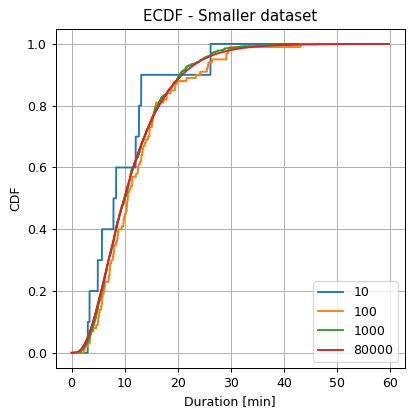

In [5]:
## Create the figure and axis
fig, ax = plt.subplots()
ax.set_title('ECDF - Smaller dataset')
ax.set_ylabel('CDF')
ax.set_xlabel('Duration [min]')

## Generate a random generator for the sampling
rand_gen = np.random.RandomState(0)

for n_samples in [10, 100, 1000, len(x)]:
    x_smaller = rand_gen.choice(x, n_samples, replace=False)
    
    ## Create the ECDF
    ecdf = calculate_ecdf(x_smaller, duration_grid)

    ## Plot the ECDF
    ax.plot(duration_grid, ecdf, label=str(n_samples))

## Add a legend
ax.legend();

Not surprisingly, we can see that as we increase the number of points, the estimation becomes smoother, and although we have not defined an evaluation method, we will note that for all the popular distribution evaluation methods the error indeed decreases.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/color/96/000000/idea-sharing.png"> Model & Learning Method Suggestion 2: Histogram

We shall try to estimate the PDF of the distribution using an histogram.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/services.png"> Learning

## <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.4 - Histogram

1. Calculate and plot the histogram of the duration for the case of 30, 300 and 3000 bins.
2. Split the train set into 8 equal subsets and calculate the histogram for each of the subsets. What can you say about the variability of the bins height as a function of the number of bins?

*Reminder: the rule of thumb suggests to use a number of bins equal to $\sqrt{N}=\sqrt{80000}\approx 280$*

### Solution 2.4

#### 1)

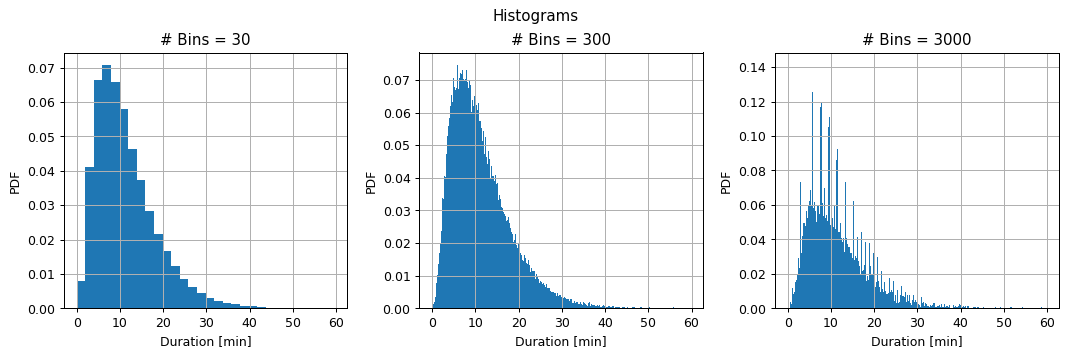

In [6]:
def calculate_hist(x, n_bins):
    ## Define bins
    bins_edges = np.linspace(0, x.max() + 1e-9, n_bins + 1)
    bins_width = np.diff(bins_edges) ## Equal to running: bins[1:] - bins[:-1]

    ## Calculate the histogram
    hist_values = np.zeros(n_bins)
    for k in range(n_bins):
        hist_values[k] = \
            np.sum((x >= bins_edges[k]) & 
                   (x < bins_edges[k + 1])
                   ) / n_samples / bins_width[k]
    
    return hist_values, bins_edges, bins_width

## Prepare the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
## Loop over the number of bins
for i_bins, n_bins in enumerate((30, 300, 3000)):
    ## Calculate the histogram
    hist_values, bins_edges, bins_width = calculate_hist(x, n_bins)
    
    ## Plot the histogram
    ax[i_bins].bar(bins_edges[:-1], hist_values, width=bins_width, align='edge');
    ax[i_bins].set_title('# Bins = {}'.format(n_bins))
    ax[i_bins].set_ylabel('PDF')
    ax[i_bins].set_xlabel('Duration [min]')

fig.suptitle('Histograms');
plt.tight_layout(rect=(0, 0, 1, 0.95))

From here on we will use the [plt.hist](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.hist.html?highlight=hist#matplotlib.axes.Axes.hist) or [numpy.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) functions for calculating histograms.

##### 2)

Let us split the data and repeat the previous calculation on each subset. 

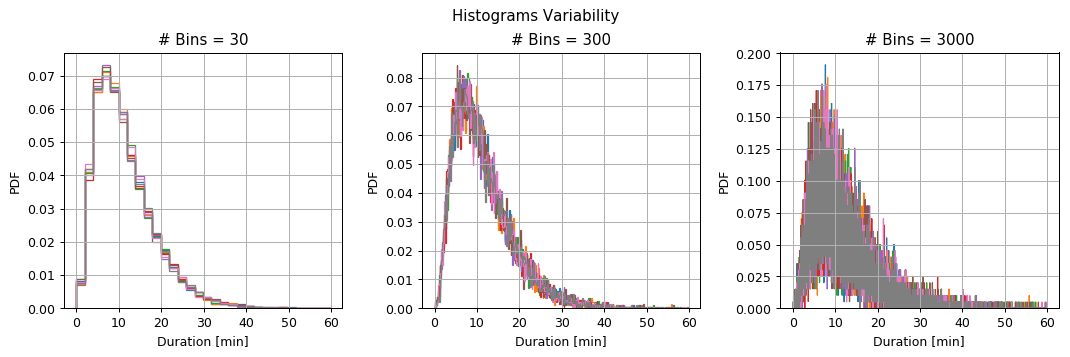

In [7]:
## Generate a random generator for the shuffling
rand_gen = np.random.RandomState(0)
## Shuffle the array (the array is copied in order to preserve the order of the original array)
x_shuffled = x.copy()
rand_gen.shuffle(x_shuffled)
## Split the shuffled array
x_splited = np.split(x_shuffled, 8)

## Prepare the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
## Loop over the number of bins
for i_bins, n_bins in enumerate([30, 300, 3000]):
    ## Define bins
    bins_edges = np.linspace(0, x.max() + 1e-9, n_bins + 1)
    
    ## Loop over the subsets
    for x_subset in x_splited:
        ## Plot histogram
        ax[i_bins].hist(x_subset, bins=bins_edges, density=True, histtype='step', fill=False);
    ax[i_bins].set_title('# Bins = {}'.format(n_bins))
    ax[i_bins].set_ylabel('PDF')
    ax[i_bins].set_xlabel('Duration [min]')

fig.suptitle('Histograms Variability');
plt.tight_layout(rect=(0, 0, 1, 0.95))

To better visualize the variance let us plot the above graphs after removing the mean value:

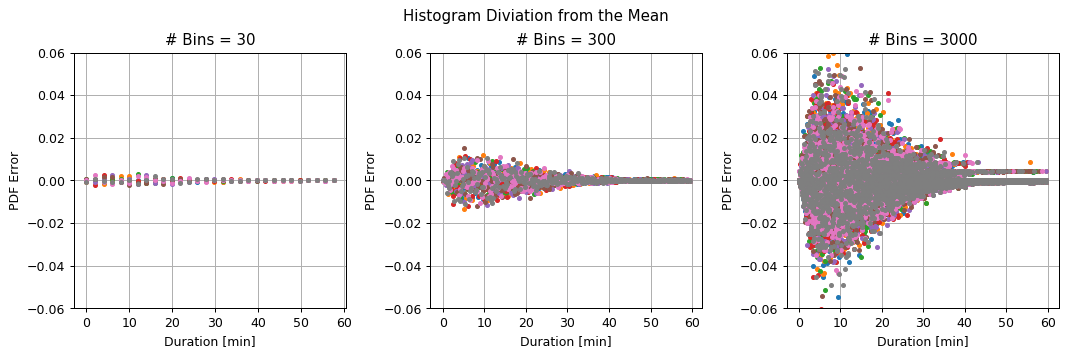

In [8]:
## Prepare the figure
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
## Loop over the number of bins
for i_bins, n_bins in enumerate([30, 300, 3000]):
    ## Define bins
    bins_edges = np.linspace(0, x.max() + 1e-9, n_bins + 1)
    
    ## Initialize an array to store the histograms values
    histograms = np.zeros((len(x_splited), len(bins_edges) - 1))
    
    ## Loop over the subsets
    for i_subset, x_subset in enumerate(x_splited):
        ## Calculate the histograms
        histograms[i_subset] = np.histogram(x_subset, bins=bins_edges, density=True)[0]

    ## Remove the mean value
    histograms_error = histograms - histograms.mean(axis=0)
    
    ## Plot the histograms error
    ax[i_bins].plot(bins_edges[:-1], histograms_error.T, '.')
    ax[i_bins].set_title('# Bins = {}'.format(n_bins))
    ax[i_bins].set_ylabel('PDF Error')
    ax[i_bins].set_xlabel('Duration [min]')
    ax[i_bins].set_ylim(-0.06, 0.06)

fig.suptitle('Histogram Diviation from the Mean');
plt.tight_layout(rect=(0, 0, 1, 0.95))

We can see that:

- **For a large number of bins**, the deviations between the subsets are large, but the bins are narrow.
- **For the small number of bins**, the deviations between the subsets are small, but the bins are wide.

##### Sources of Estimation Error

- In the first case, the main source of error is due to the stochastic nature of the process which results in a large variance in our estimation. This error will be very significant for a small amount of data, but it will decrease as we add more data.

- In the second case, the main source of estimation error will be mostly due to the model's limited representation capability. This type of error is unrelated to the amount of data.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/color/96/000000/idea-sharing.png"> Model & Learning Method Suggestion 3: KDE

We shall try to estimate the PDF of the distribution using an KDE.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/services.png"> Learning

## <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.5 - KDE

Calculate and plot the KDE of the durations using a Gaussian Parzen window with widths ($\sigma$) of 0.08, 0.8, 8. 

Add on the same axes the plot of a histogram with 300 bins for comparison.

*Reminder: the rule of thumb suggests a width of: $\left(\frac{4\cdot\text{std}\left\{x_i\right\}}{3N}\right)^\frac{1}{5}$*

### Solution 2.5

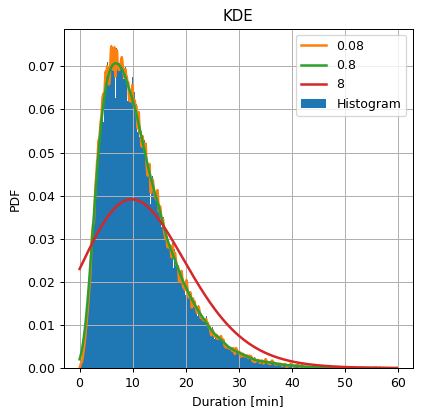

In [9]:
## Calculate the suggested bandwidth
suggested_bandwidth = 1.06 * np.std(x) / n_samples ** (1 / 5.)
print_math('The rule of thumb suggests a bandwidth of $\\left(\\frac{{4\\cdot\\text{{std}}\\left\\{{x_i\\right\\}}}}{{3N}}\\right)^\\frac{{1}}{{5}}\\approx{:.3f}$'.format(suggested_bandwidth))

def calculate_gaussian_kde(x, bandwidth, duration_grid):
    ## Calculate a matrix of (x_grid_j - x_i)^2 
    delta_squared = (duration_grid[:, None] - x[None, :]) ** 2

    ## Calculate the KDE
    kde = (1 / np.sqrt(2 * np.pi * bandwidth ** 2) * np.exp(- delta_squared / 2 / bandwidth ** 2)).mean(axis=1)
    
    return kde

## Define the grid
duration_grid = np.arange(0, x.max() + 0.01, 0.01)

## Prepare the figure
fig, ax = plt.subplots()
ax.hist(x, bins=300 ,density=True, label='Histogram')
## Loop over the bandwidth
for i_bandwidth, bandwidth in enumerate([0.08, 0.8, 8]):
    ## Calculate KDE
    kde = calculate_gaussian_kde(x, bandwidth, duration_grid)
    
    ## Plot histogram
    ax.plot(duration_grid, kde, linewidth=2, label=str(bandwidth))

ax.set_title('KDE')
ax.set_ylabel('PDF')
ax.set_xlabel('Duration [min]')
ax.legend();

From here on we will use the [KernelDensity](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity) object from scikit-learn to calculate KDEs.

Again we see behavior similar to that of the histogram. For a narrow bandwidth, we get finer details, but the estimation is more "noisy", which is related to the high variance of the estimation. For the wide bandwidth, we get fewer details, but we expect the estimation to have smaller variance.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.6 - Work Hours Prediction 1

We would like to predict whether a random given ride occurred during the work hours, , which we will define as between 7 a.m. and 18 p.m., based only on the duration of the ride.

For that let as define the random binary variable $Y$. The random variable $Y$ returns 1 if a ride occurred during the work hours, and 0 otherwise.

We shall denote $p_Y\left(y\right)=P\left(Y=y\right)$

1. Based on the data estimate $p_Y\left(0\right)$ and $p_Y\left(1\right)$, the probability of a random ride to occur on and off the work hours
2. Which of the constant predictions, 0 or 1, would result in a larger probability guess $Y$ correctly?

## solution 2.6

### 1)

We will estimate $p_Y\left(y\right)$ using the empirical measure estimation: $\frac{1}{N}\sum_i I\left\{y_i=y\right\}$

In [10]:
## Define {y}
y = (train_set['time_of_day'].values > 7) & (train_set['time_of_day'].values < 18)

## Calculate the probability p_Y(1)
prob_y1 = y.mean()
print_math('$p_Y(1)\\approx{:.2f}$'.format(prob_y1))

## Calculate the probability p_Y(0)
prob_y0 = (~y).mean()
print_math('$p_Y(0)\\approx{:.2f}$'.format(prob_y0))

#### 2)

Basically, we would like to select our constant prediction $\hat{y}$ such that:

$$
\hat{y}=\underset{y\in\left\{0,1\right\}}{\arg\max}\ \ P\left(Y=y\right)
$$

Which, not surprisingly, means picking the value of $Y$ with the highest probability.Since there is a slightly higher probability of $Y$ being equal to 1 our constant prediction would be:

$$
\hat{y}=1
$$

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/color/96/000000/speedometer.png"> Performance evaluation - Constant Prediction

Let us test our prediction method on the test set, using the misclassification rate risk:

In [11]:
## Define {y} for the test test
y_test = (test_set['time_of_day'].values > 7) & (test_set['time_of_day'].values < 18)

predictions = 1
test_risk = (y_test != predictions).mean()
print_math('The test risk is: $R_\\text{{test}}\\{{ \\hat{{y}}=1 \\}}={:.2}$'.format(test_risk))

Similarly to the train set we we're correct 51% of the time, which is only slightly better then a 50:50 random guess.

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/plasticine/100/000000/create-new.png"> Exercise 2.7 - Work Hours Prediction 2

Let us now try to improve our prediction using the duration data. We would now like to make our prediction based on the the known duration of the ride, i.e., we would like to predict:

$$
\hat{y}\left(x\right)=\underset{y\in\left\{0,1\right\}}{\arg\max}\ \ p_{Y|X}\left(y|x\right)
$$

1. Use Bayes rule to write $p_{Y|X}$ using $p_{X|Y}$, $p_X$ and $p_Y$
2. Use KDE to estimate $p_{X|Y}\left(x|y=0\right)$ and $p_{X|Y}\left(x|y=1\right)$.
3. Calculate the new predictor. 

### solution 2.7

#### 1)

Using Bayes rule:
$$
p_{Y|X}\left(y|x\right)=\frac{p_{X|Y}\left(x|y\right)\cdot p_Y\left(y\right)}{p_X\left(x\right)}
$$

#### 2)

To evaluate $p_{X|Y}\left(x|y=1\right)$ we will calculate a KDE using only the samples with $Y=1$, and the same for $p_{X|Y}\left(x|y=0\right)$ 

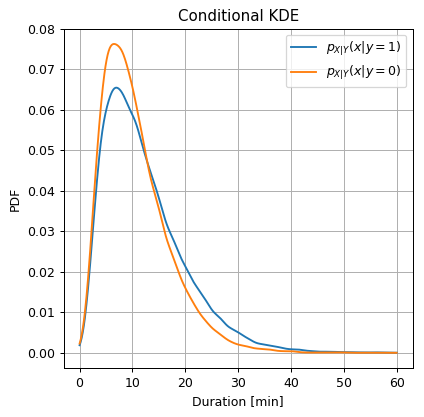

In [12]:
## Import the KDE class from scikit-learn
from sklearn.neighbors import KernelDensity

## Define the grid
duration_grid = np.arange(0, 60 + 0.1, 0.1)

## Initialize a KDE estimation object
kde_func = KernelDensity(kernel='gaussian', bandwidth=0.8)

## Y=1
## Update the KDE object with the data for Y=1
kde_func.fit(x[y, None])
## Calculate the desity over the grid
kde_y1 = np.exp(kde_func.score_samples(duration_grid[:, None]))  ## score_samples retuns log(p(x))

## Y=0
## Update the KDE object with the data for Y=1
kde_func.fit(x[~y, None])
## Calculate the desity over the grid
kde_y0 = np.exp(kde_func.score_samples(duration_grid[:, None]))  ## score_samples retuns log(p(x))

fig, ax = plt.subplots()
ax.plot(duration_grid, kde_y1, label='$p_{X|Y}(x|y=1)$')
ax.plot(duration_grid, kde_y0, label='$p_{X|Y}(x|y=0)$')
ax.set_title('Conditional KDE')
ax.set_ylabel('PDF')
ax.set_xlabel('Duration [min]')
ax.legend();

We can see here that during the work hours, $Y=1$, a ride has a slightly higher probability to have a longer duration. Let us see if we can use this fact to improve our prediction.

#### 3)

The result of 

$$
\hat{y}\left(x\right)=\underset{y\in\left\{0,1\right\}}{\arg\max}\ \ p_{Y|X}\left(y|x\right)
$$

will simply be:

$$
\hat{y}\left(x\right)
=\underset{y\in\left\{0,1\right\}}{\arg\max}\ \  p_{Y|X}\left(y|x\right)
= 
\begin{cases}
1 & p_{Y|X}\left(y=1|x\right)\geq p_{X|Y}\left(y=0|x\right) \\
0 & \text{otherwise}
\end{cases}
$$

Let us use the Bayes equality we wrote in order to evaluate the condition here:

$$
p_{Y|X}\left(1|x\right)\overset{?}{\geq}p_{Y|X}\left(0|x\right) \\
\Leftrightarrow
\frac{p_{X|Y}\left(x|1\right)\cdot p_Y\left(1\right)}{p_X\left(x\right)}\overset{?}{\geq}\frac{p_{X|Y}\left(x|0\right)\cdot p_Y\left(0\right)}{p_X\left(x\right)} \\
\Leftrightarrow
p_{X|Y}\left(x|1\right)\cdot p_Y\left(1\right)\overset{?}{\geq}p_{X|Y}\left(x|0\right)\cdot p_Y\left(0\right)
$$

We will evaluate $\hat{y}$ numerically by substituting the quantities which we have already calculated into this inequality:

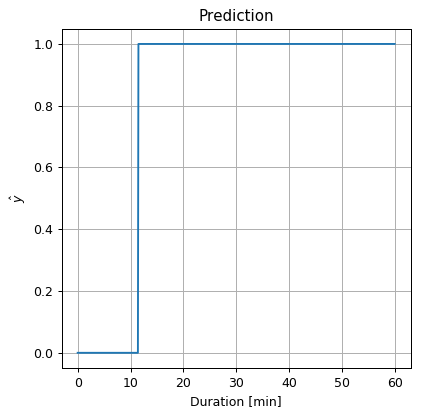

In [13]:
## Calculate the prediction over the grid
prediction = kde_y1 * prob_y1 >= kde_y0 * prob_y0

## Plot the prediction
fig, ax = plt.subplots()
ax.plot(duration_grid, prediction)
ax.set_title('Prediction')
ax.set_ylabel('$\hat{y}$')
ax.set_xlabel('Duration [min]');

Therefore our prediction would be:

$$
\hat{y}\left(x\right)=
\begin{cases}
1 & x\geq11.4 \\
0 & \text{otherwise}
\end{cases}
$$

# <img style="display:inline;height:50px" height="50px" src="https://img.icons8.com/color/96/000000/speedometer.png"> Performance evaluation - Based on Duration

Let us test our prediction method on the test set:

In [14]:
x_test = test_set['duration'].values

predictions = x_test > 11.4
test_risk = (y_test != predictions).mean()
print_math('The test risk is: $R_\\text{{test}}\\{{ \\hat{{y}}(x) \\}}={:.2}$'.format(test_risk))

We were able to slightly improve our prediction. Although it is a very small improvement, there are cases where it can be very significant.

# <img style="display:inline;height:50px" height="50px" src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Cc-by_new.svg">  Attributions
Icons in these notebooks were made by:
- <https://icons8.com> is licensed by  [CC 3.0 BY-ND](http://creativecommons.org/licenses/by-nd/3.0/)
- [Freepik](https://www.freepik.com) from <https://www.flaticon.com> is licensed by [CC 3.0 BY](http://creativecommons.org/licenses/by/3.0/)

In [15]:
%%html
<link rel="stylesheet" href="../css/style.css"> <!--Setting styles - You can simply ignore this line-->